# PyMC model

This notebook shows a PyMC model that incorporates basket + clustering

In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
import sys
from os.path import exists

sys.path.append('..')
sys.path.append('.')

In [3]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
from sklearn.metrics import mean_squared_error
import math
from statsmodels.formula.api import glm
import statsmodels.api as sm
import seaborn as sns

from scipy import stats
from scipy.special import expit as logistic

In [4]:
from pyBasket.common import load_obj
from pyBasket.model import get_patient_model_simple, get_patient_model_hierarchical
from pyBasket.model import get_patient_model_hierarchical_log_odds, get_patient_model_hierarchical_log_odds_nc

## 1. Generate some data

In [5]:
np.random.seed(42)

In [6]:
# set the number of baskets and clusters
n_baskets = 25
n_clusters = 10

# generate some synthetic basket and cluster probabilities
true_basket_p = np.random.beta(1, 1, size=n_baskets)
true_cluster_p = np.random.beta(1, 1, size=n_clusters)
true_mat = np.outer(true_basket_p, true_cluster_p)
true_basket_p, true_cluster_p, true_mat

(array([0.50003865, 0.06284339, 0.02078204, 0.4978376 , 0.36699967,
        0.59729045, 0.81434157, 0.44364733, 0.27969111, 0.92729229,
        0.78083675, 0.7572072 , 0.19772398, 0.03643975, 0.28088499,
        0.37475224, 0.74731634, 0.31107264, 0.12205197, 0.5888815 ,
        0.34109285, 0.14942324, 0.79534112, 0.00672622, 0.91240585]),
 array([0.75572304, 0.83887103, 0.4888386 , 0.14359827, 0.55008652,
        0.19067603, 0.04706098, 0.38199756, 0.74824909, 0.64250325]),
 array([[3.77890731e-01, 4.19467938e-01, 2.44438194e-01, 7.18046864e-02,
         2.75064520e-01, 9.53453836e-02, 2.35323088e-02, 1.91013545e-01,
         3.74153465e-01, 3.21276461e-01],
        [4.74921943e-02, 5.27174953e-02, 3.07202724e-02, 9.02420154e-03,
         3.45692989e-02, 1.19827270e-02, 2.95747128e-03, 2.40060199e-02,
         4.70225057e-02, 4.03770796e-02],
        [1.57054674e-02, 1.74334522e-02, 1.01590639e-02, 2.98426520e-03,
         1.14319206e-02, 3.96263705e-03, 9.78023217e-04, 7.93868903e-03

In [7]:
# generate some synthetic data
data = []
for i in range(n_baskets):
    for j in range(n_clusters):
        
        # probability of a patient being responsive in this basket and cluster combination
        p = true_basket_p[i] * true_cluster_p[j]
        
        # number of patients in this basket and cluster
        n = np.random.randint(1, 5)
        
        # generate the data
        responsive = np.random.binomial(1, p, size=n)
        data += [(i, j, r) for r in responsive]

# convert the data to a pandas dataframe
data = pd.DataFrame(data, columns=['basket_number', 'cluster_number', 'responsive'])
data

basket_number  cluster_number  responsive
0                0               0           1
1                0               0           0
2                0               1           1
3                0               2           0
4                0               2           0
..             ...             ...         ...
610             24               8           1
611             24               9           1
612             24               9           0
613             24               9           1
614             24               9           0

[615 rows x 3 columns]

## 2. Define models

No. of samples to collect before and after burn-in during MCMC.

In [8]:
n_burn_in = int(1E4)
n_sample = int(1E4)
target_accept = 0.99

### Simple model

In [9]:
model_s = get_patient_model_simple(data)

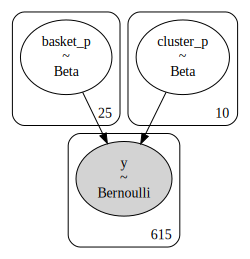

In [10]:
pm.model_to_graphviz(model_s)

In [11]:
with model_s:
    trace_s = pm.sample(n_sample, tune=n_burn_in, idata_kwargs={'log_likelihood': True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [basket_p, cluster_p]


Sampling 4 chains for 10_000 tune and 10_000 draw iterations (40_000 + 40_000 draws total) took 47 seconds.


In [12]:
az.summary(trace_s).round(2)

mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
basket_p[0]   0.39  0.12    0.18     0.62        0.0      0.0   83201.0   
basket_p[1]   0.19  0.09    0.04     0.35        0.0      0.0   73461.0   
basket_p[2]   0.08  0.05    0.00     0.18        0.0      0.0   71076.0   
basket_p[3]   0.45  0.10    0.26     0.65        0.0      0.0   76325.0   
basket_p[4]   0.36  0.10    0.18     0.55        0.0      0.0   87313.0   
basket_p[5]   0.23  0.09    0.07     0.40        0.0      0.0   78435.0   
basket_p[6]   0.52  0.11    0.30     0.73        0.0      0.0   82771.0   
basket_p[7]   0.32  0.10    0.14     0.50        0.0      0.0   85305.0   
basket_p[8]   0.15  0.08    0.02     0.30        0.0      0.0   77193.0   
basket_p[9]   0.58  0.11    0.38     0.79        0.0      0.0   79206.0   
basket_p[10]  0.56  0.11    0.35     0.77        0.0      0.0   86296.0   
basket_p[11]  0.38  0.11    0.18     0.58        0.0      0.0   85711.0   
basket_p[12]  0.30  0.10    0.13     0.49        0.0      0.0   75656.0   
basket_p[13]  0.10  0.07    0.00     0.22        0.0      0.0   76847.0   
basket_p[14]  0.28  0.10    0.10     0.46        0.0      0.0   78240.0   
basket_p[15]  0.18  0.08    0.04     0.33        0.0      0.0   77302.0   
basket_p[16]  0.57  0.11    0.37     0.78        0.0      0.0   84401.0   
basket_p[17]  0.22  0.10    0.05     0.40        0.0      0.0   80819.0   
basket_p[18]  0.12  0.06    0.02     0.24        0.0      0.0   78111.0   
basket_p[19]  0.36  0.10    0.18     0.56        0.0      0.0   82822.0   
basket_p[20]  0.30  0.09    0.14     0.47        0.0      0.0   79748.0   
basket_p[21]  0.14  0.08    0.02     0.28        0.0      0.0   82057.0   
basket_p[22]  0.45  0.11    0.25     0.66        0.0      0.0   84612.0   
basket_p[23]  0.10  0.06    0.00     0.21        0.0      0.0   70480.0   
basket_p[24]  0.65  0.10    0.46     0.84        0.0      0.0   83472.0   
cluster_p[0]  0.84  0.09    0.69     0.99        0.0      0.0   61985.0   
cluster_p[1]  0.91  0.06    0.80     1.00        0.0      0.0   63381.0   
cluster_p[2]  0.74  0.11    0.53     0.95        0.0      0.0   61757.0   
cluster_p[3]  0.30  0.10    0.13     0.48        0.0      0.0   83511.0   
cluster_p[4]  0.82  0.10    0.65     0.98        0.0      0.0   61187.0   
cluster_p[5]  0.30  0.11    0.10     0.50        0.0      0.0   83409.0   
cluster_p[6]  0.28  0.11    0.09     0.48        0.0      0.0   80509.0   
cluster_p[7]  0.61  0.13    0.37     0.85        0.0      0.0   66425.0   
cluster_p[8]  0.89  0.06    0.78     1.00        0.0      0.0   64701.0   
cluster_p[9]  0.74  0.11    0.54     0.95        0.0      0.0   58071.0   

              ess_tail  r_hat  
basket_p[0]    28814.0    1.0  
basket_p[1]    28087.0    1.0  
basket_p[2]    27860.0    1.0  
basket_p[3]    29380.0    1.0  
basket_p[4]    28553.0    1.0  
basket_p[5]    28405.0    1.0  
basket_p[6]    31100.0    1.0  
basket_p[7]    30482.0    1.0  
basket_p[8]    29863.0    1.0  
basket_p[9]    26406.0    1.0  
basket_p[10]   30207.0    1.0  
basket_p[11]   27983.0    1.0  
basket_p[12]   28696.0    1.0  
basket_p[13]   25591.0    1.0  
basket_p[14]   27989.0    1.0  
basket_p[15]   28320.0    1.0  
basket_p[16]   28916.0    1.0  
basket_p[17]   28485.0    1.0  
basket_p[18]   24872.0    1.0  
basket_p[19]   30417.0    1.0  
basket_p[20]   29178.0    1.0  
basket_p[21]   26299.0    1.0  
basket_p[22]   29683.0    1.0  
basket_p[23]   24032.0    1.0  
basket_p[24]   28905.0    1.0  
cluster_p[0]   25348.0    1.0  
cluster_p[1]   25427.0    1.0  
cluster_p[2]   26891.0    1.0  
cluster_p[3]   31461.0    1.0  
cluster_p[4]   24556.0    1.0  
cluster_p[5]   29569.0    1.0  
cluster_p[6]   30247.0    1.0  
cluster_p[7]   25831.0    1.0  
cluster_p[8]   26631.0    1.0  
cluster_p[9]   24732.0    1.0

array([[<AxesSubplot: title={'center': 'basket_p\n0'}, xlabel='Total number of draws', ylabel='ESS'>,
        <AxesSubplot: title={'center': 'basket_p\n1'}, xlabel='Total number of draws', ylabel='ESS'>,
        <AxesSubplot: title={'center': 'basket_p\n2'}, xlabel='Total number of draws', ylabel='ESS'>,
        <AxesSubplot: title={'center': 'basket_p\n3'}, xlabel='Total number of draws', ylabel='ESS'>],
       [<AxesSubplot: title={'center': 'basket_p\n4'}, xlabel='Total number of draws', ylabel='ESS'>,
        <AxesSubplot: title={'center': 'basket_p\n5'}, xlabel='Total number of draws', ylabel='ESS'>,
        <AxesSubplot: title={'center': 'basket_p\n6'}, xlabel='Total number of draws', ylabel='ESS'>,
        <AxesSubplot: title={'center': 'basket_p\n7'}, xlabel='Total number of draws', ylabel='ESS'>],
       [<AxesSubplot: title={'center': 'basket_p\n8'}, xlabel='Total number of draws', ylabel='ESS'>,
        <AxesSubplot: title={'center': 'basket_p\n9'}, xlabel='Total number of d

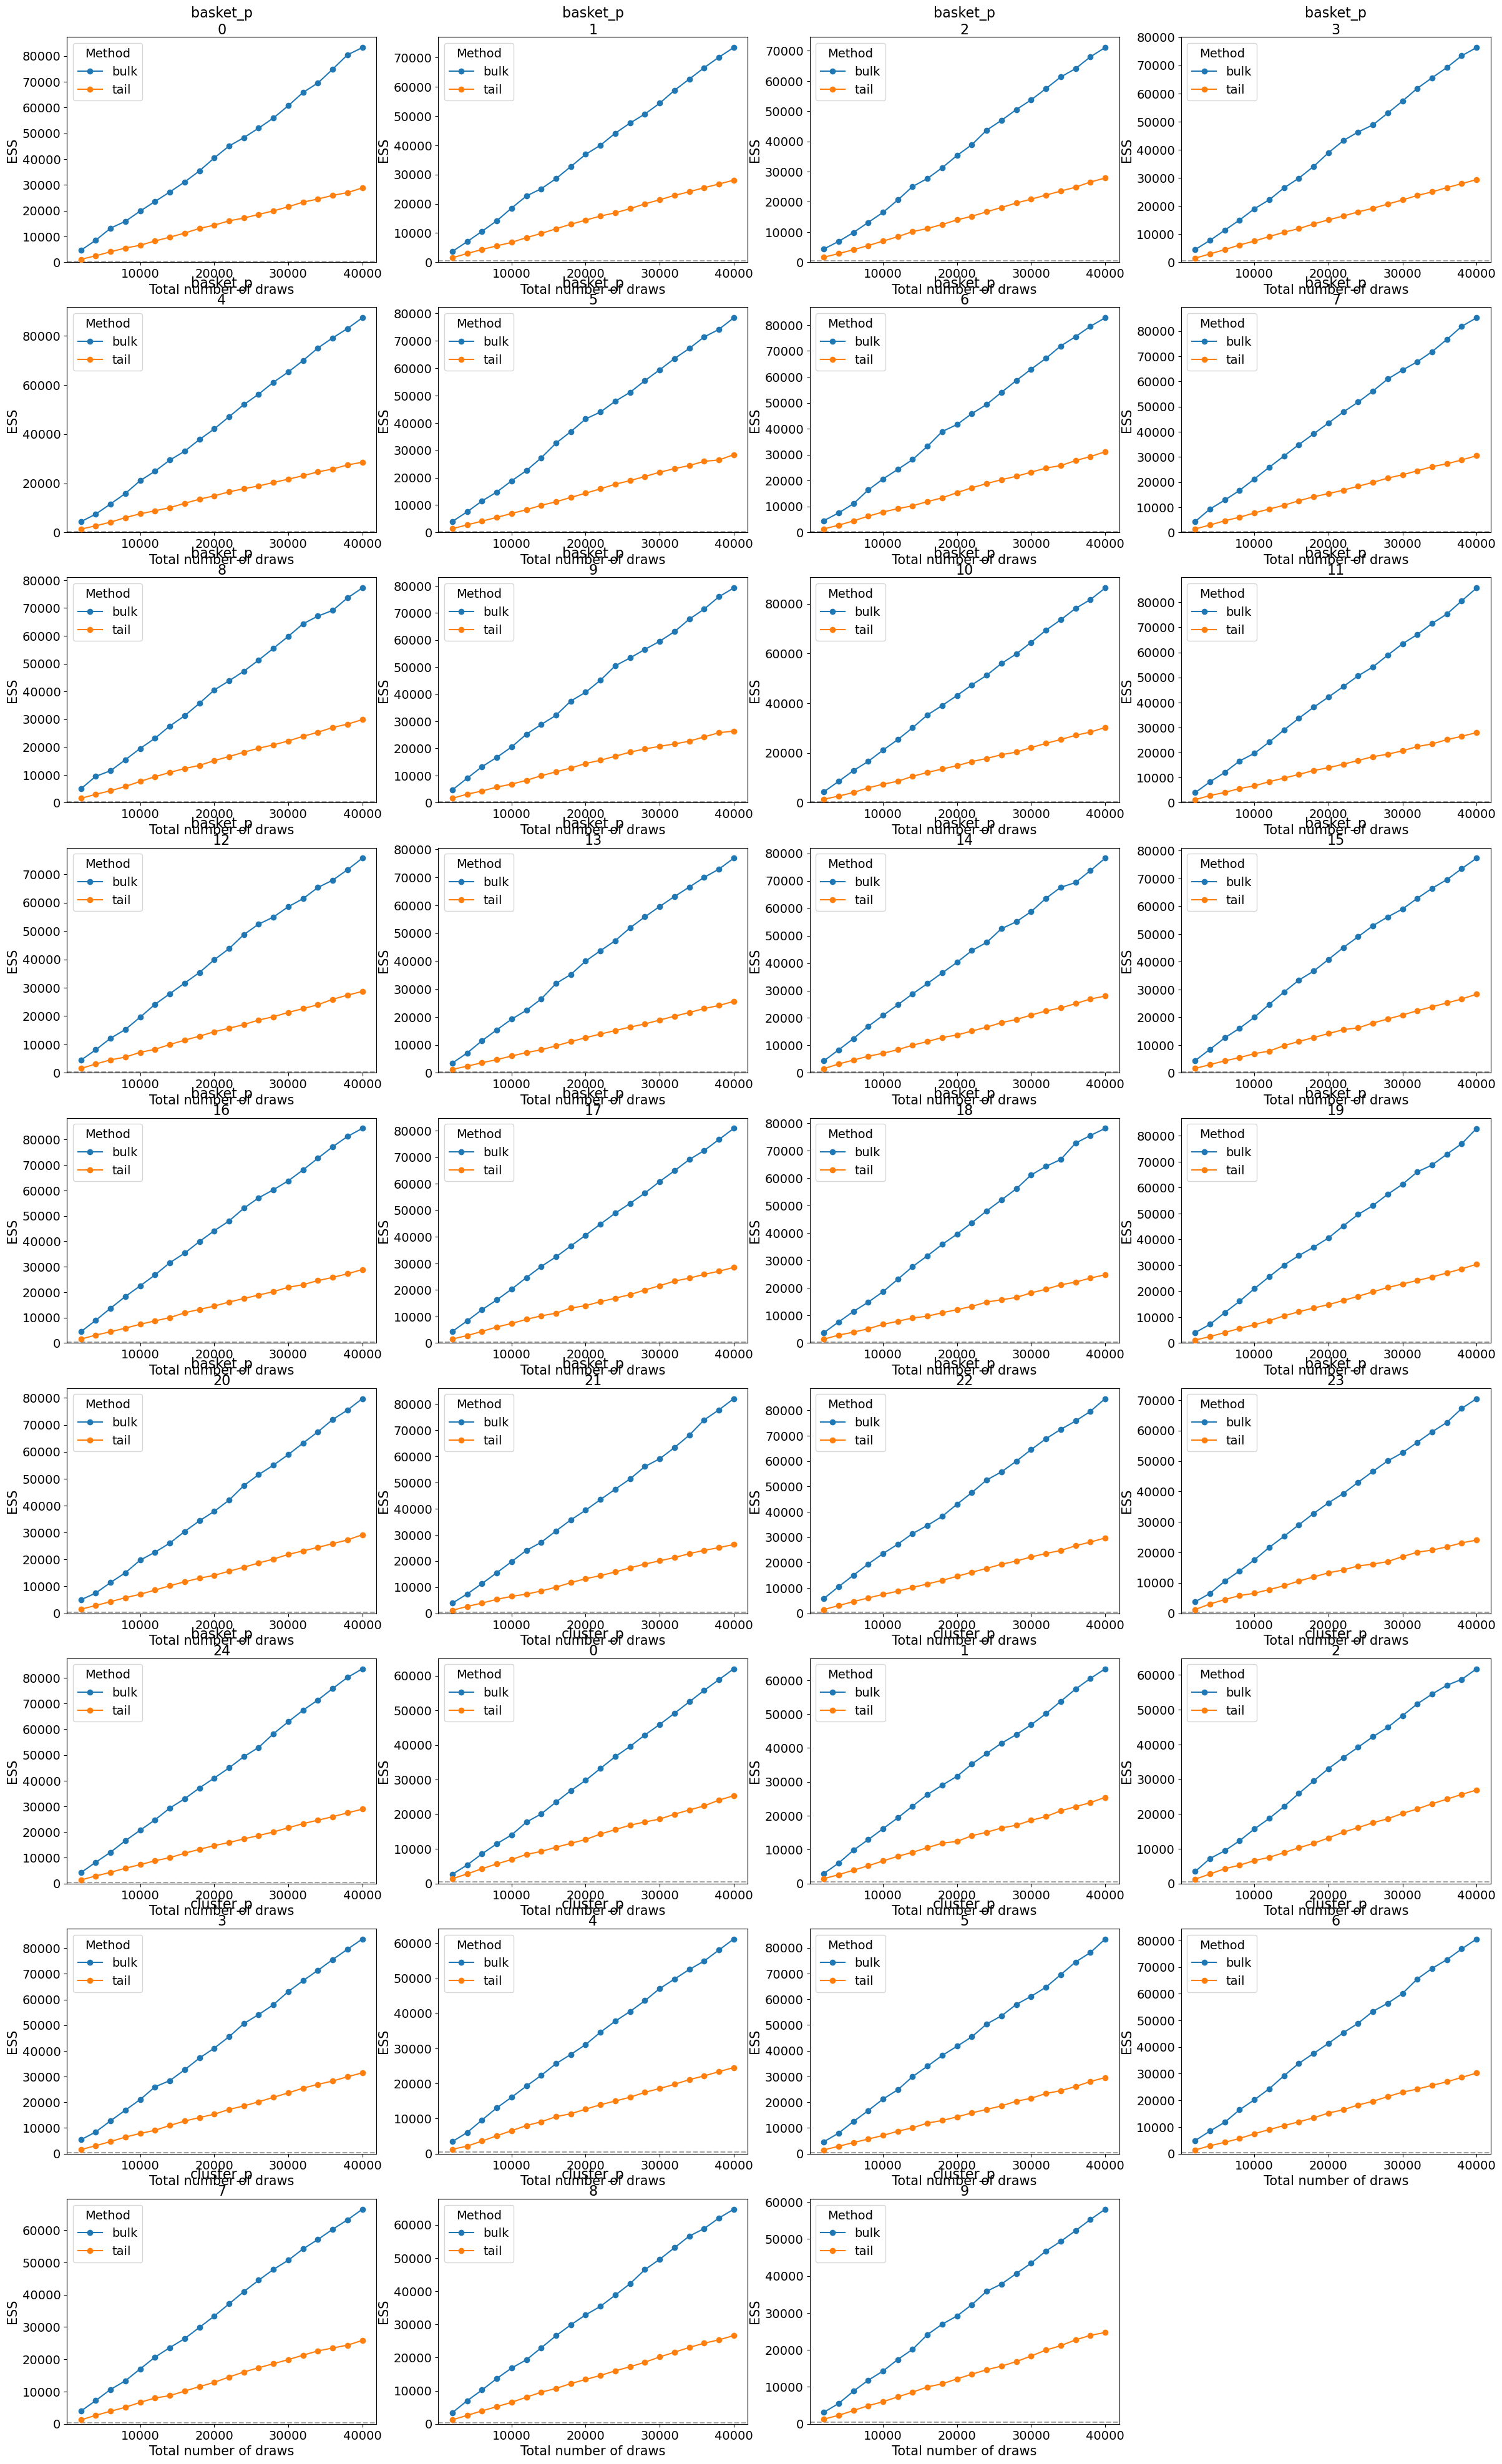

In [13]:
az.plot_ess(
    trace_s, kind="evolution", var_names=['basket_p', 'cluster_p']
)

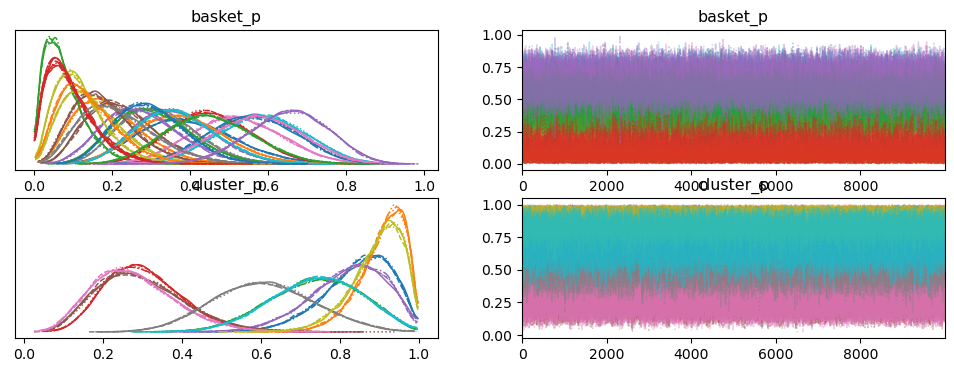

In [14]:
az.plot_trace(trace_s, var_names=['basket_p', 'cluster_p']);

array([<AxesSubplot: title={'center': '94.0% HDI'}>], dtype=object)

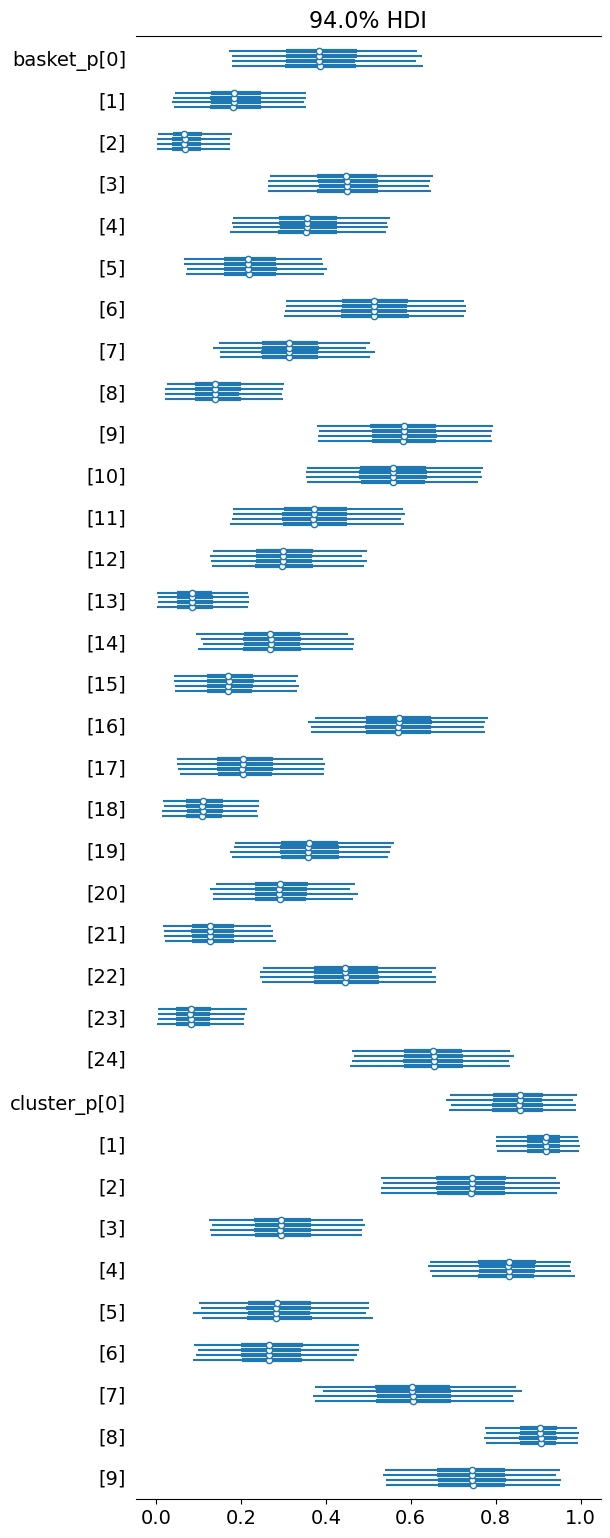

In [15]:
az.plot_forest(trace_s, var_names=['basket_p', 'cluster_p'])

In [16]:
stacked_s = az.extract(trace_s)

In [17]:
inferred_basket_p = stacked_s.basket_p.values[:, 0]
true_basket_p, inferred_basket_p, math.sqrt(mean_squared_error(true_basket_p, inferred_basket_p))

(array([0.50003865, 0.06284339, 0.02078204, 0.4978376 , 0.36699967,
        0.59729045, 0.81434157, 0.44364733, 0.27969111, 0.92729229,
        0.78083675, 0.7572072 , 0.19772398, 0.03643975, 0.28088499,
        0.37475224, 0.74731634, 0.31107264, 0.12205197, 0.5888815 ,
        0.34109285, 0.14942324, 0.79534112, 0.00672622, 0.91240585]),
 array([0.45480798, 0.08215179, 0.02253598, 0.57759914, 0.37988743,
        0.30325109, 0.48891179, 0.40224943, 0.23302265, 0.62634181,
        0.53805214, 0.3165633 , 0.48650863, 0.12735529, 0.28312293,
        0.16382836, 0.68579747, 0.17061172, 0.09245977, 0.59877765,
        0.25897819, 0.05996788, 0.23462525, 0.07677243, 0.6477141 ]),
 0.21105893545223922)

In [18]:
inferred_cluster_p = stacked_s.cluster_p.values[:, 0]
true_cluster_p, inferred_cluster_p, math.sqrt(mean_squared_error(true_cluster_p, inferred_cluster_p))

(array([0.75572304, 0.83887103, 0.4888386 , 0.14359827, 0.55008652,
        0.19067603, 0.04706098, 0.38199756, 0.74824909, 0.64250325]),
 array([0.73297679, 0.90973245, 0.85097258, 0.38120505, 0.7903691 ,
        0.22011569, 0.10171762, 0.78538315, 0.89440833, 0.48690811]),
 0.2151787172418739)

In [19]:
inferred_mat_s = np.outer(inferred_basket_p, inferred_cluster_p)
true_mat, inferred_mat_s

(array([[3.77890731e-01, 4.19467938e-01, 2.44438194e-01, 7.18046864e-02,
         2.75064520e-01, 9.53453836e-02, 2.35323088e-02, 1.91013545e-01,
         3.74153465e-01, 3.21276461e-01],
        [4.74921943e-02, 5.27174953e-02, 3.07202724e-02, 9.02420154e-03,
         3.45692989e-02, 1.19827270e-02, 2.95747128e-03, 2.40060199e-02,
         4.70225057e-02, 4.03770796e-02],
        [1.57054674e-02, 1.74334522e-02, 1.01590639e-02, 2.98426520e-03,
         1.14319206e-02, 3.96263705e-03, 9.78023217e-04, 7.93868903e-03,
         1.55501433e-02, 1.33525291e-02],
        [3.76227347e-01, 4.17621541e-01, 2.43362236e-01, 7.14886194e-02,
         2.73853752e-01, 9.49256961e-02, 2.34287253e-02, 1.90172750e-01,
         3.72506531e-01, 3.19862279e-01],
        [2.77350109e-01, 3.07865393e-01, 1.79403606e-01, 5.27005189e-02,
         2.01881572e-01, 6.99780397e-02, 1.72713642e-02, 1.40192980e-01,
         2.74607170e-01, 2.35798484e-01],
        [4.51386155e-01, 5.01049654e-01, 2.91978626e-01, 8.5

### Hierarchical model 1

This hierarchical model suffers from a lot of divergences. See:
- https://discourse.pymc.io/t/non-centered-parameterization-of-a-beta-distribution/6872/7
- https://stats.stackexchange.com/questions/67443/does-the-beta-distribution-have-a-conjugate-prior

In [20]:
model_h1 = get_patient_model_hierarchical(data)

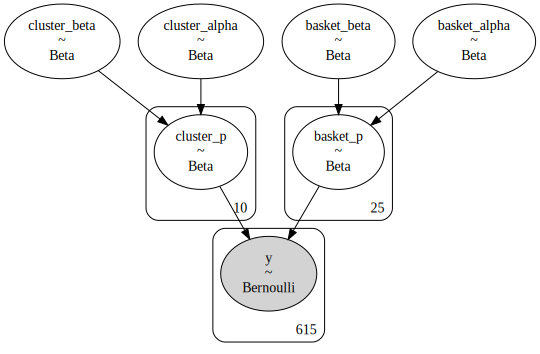

In [21]:
pm.model_to_graphviz(model_h1)

In [22]:
with model_h1:
    trace_h1 = pm.sample(n_sample, tune=n_burn_in, idata_kwargs={'log_likelihood': True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [basket_alpha, basket_beta, cluster_alpha, cluster_beta, basket_p, cluster_p]


Sampling 4 chains for 10_000 tune and 10_000 draw iterations (40_000 + 40_000 draws total) took 96 seconds.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


In [23]:
az.summary(trace_h1).round(2)

mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
basket_alpha   0.68  0.16    0.42     0.98        0.0      0.0   18490.0   
basket_beta    0.77  0.17    0.47     1.00        0.0      0.0    7922.0   
cluster_alpha  0.68  0.18    0.38     1.00        0.0      0.0   31462.0   
cluster_beta   0.71  0.19    0.38     1.00        0.0      0.0   11668.0   
basket_p[0]    0.68  0.20    0.35     1.00        0.0      0.0   15091.0   
basket_p[1]    0.23  0.13    0.03     0.47        0.0      0.0   46255.0   
basket_p[2]    0.04  0.05    0.00     0.14        0.0      0.0   28508.0   
basket_p[3]    0.68  0.15    0.44     1.00        0.0      0.0   12094.0   
basket_p[4]    0.51  0.15    0.24     0.81        0.0      0.0   15198.0   
basket_p[5]    0.30  0.14    0.06     0.56        0.0      0.0   37818.0   
basket_p[6]    0.84  0.14    0.59     1.00        0.0      0.0   16105.0   
basket_p[7]    0.48  0.16    0.18     0.78        0.0      0.0   15056.0   
basket_p[8]    0.18  0.13    0.00     0.40        0.0      0.0   41502.0   
basket_p[9]    0.86  0.11    0.66     1.00        0.0      0.0   14738.0   
basket_p[10]   0.82  0.13    0.59     1.00        0.0      0.0   13040.0   
basket_p[11]   0.59  0.18    0.27     0.95        0.0      0.0   14590.0   
basket_p[12]   0.42  0.16    0.14     0.71        0.0      0.0   20228.0   
basket_p[13]   0.06  0.08    0.00     0.20        0.0      0.0   31525.0   
basket_p[14]   0.38  0.16    0.11     0.67        0.0      0.0   19755.0   
basket_p[15]   0.22  0.12    0.02     0.44        0.0      0.0   49526.0   
basket_p[16]   0.86  0.12    0.65     1.00        0.0      0.0   14199.0   
basket_p[17]   0.29  0.16    0.03     0.59        0.0      0.0   36371.0   
basket_p[18]   0.11  0.08    0.00     0.27        0.0      0.0   50197.0   
basket_p[19]   0.54  0.16    0.24     0.86        0.0      0.0   15331.0   
basket_p[20]   0.41  0.14    0.16     0.67        0.0      0.0   23919.0   
basket_p[21]   0.14  0.11    0.00     0.34        0.0      0.0   41594.0   
basket_p[22]   0.72  0.17    0.44     1.00        0.0      0.0   12116.0   
basket_p[23]   0.06  0.07    0.00     0.18        0.0      0.0   31208.0   
basket_p[24]   0.88  0.10    0.70     1.00        0.0      0.0   13194.0   
cluster_p[0]   0.72  0.14    0.50     1.00        0.0      0.0    7874.0   
cluster_p[1]   0.88  0.10    0.71     1.00        0.0      0.0    8002.0   
cluster_p[2]   0.51  0.12    0.30     0.73        0.0      0.0   16319.0   
cluster_p[3]   0.11  0.06    0.02     0.22        0.0      0.0   42805.0   
cluster_p[4]   0.64  0.13    0.40     0.89        0.0      0.0    9220.0   
cluster_p[5]   0.07  0.05    0.00     0.17        0.0      0.0   43029.0   
cluster_p[6]   0.07  0.05    0.00     0.16        0.0      0.0   40789.0   
cluster_p[7]   0.37  0.11    0.18     0.58        0.0      0.0   21416.0   
cluster_p[8]   0.86  0.10    0.68     1.00        0.0      0.0    8765.0   
cluster_p[9]   0.52  0.12    0.30     0.74        0.0      0.0   14919.0   

               ess_tail  r_hat  
basket_alpha    20141.0    1.0  
basket_beta      6947.0    1.0  
cluster_alpha   20074.0    1.0  
cluster_beta     9574.0    1.0  
basket_p[0]     11781.0    1.0  
basket_p[1]     25781.0    1.0  
basket_p[2]     15081.0    1.0  
basket_p[3]      8237.0    1.0  
basket_p[4]      8588.0    1.0  
basket_p[5]     26876.0    1.0  
basket_p[6]     14888.0    1.0  
basket_p[7]      8943.0    1.0  
basket_p[8]     22801.0    1.0  
basket_p[9]     11154.0    1.0  
basket_p[10]    10110.0    1.0  
basket_p[11]     9704.0    1.0  
basket_p[12]    11969.0    1.0  
basket_p[13]    17581.0    1.0  
basket_p[14]    13937.0    1.0  
basket_p[15]    24278.0    1.0  
basket_p[16]    14265.0    1.0  
basket_p[17]    20717.0    1.0  
basket_p[18]    24172.0    1.0  
basket_p[19]     9206.0    1.0  
basket_p[20]    17675.0    1.0  
basket_p[21]    22332.0    1.0  
basket_p[22]     7844.0    1.0  
basket_p[23]    17633.0    1.0  
basket_p[24]    1

array([[<AxesSubplot: title={'center': 'basket_p\n0'}, xlabel='Total number of draws', ylabel='ESS'>,
        <AxesSubplot: title={'center': 'basket_p\n1'}, xlabel='Total number of draws', ylabel='ESS'>,
        <AxesSubplot: title={'center': 'basket_p\n2'}, xlabel='Total number of draws', ylabel='ESS'>,
        <AxesSubplot: title={'center': 'basket_p\n3'}, xlabel='Total number of draws', ylabel='ESS'>],
       [<AxesSubplot: title={'center': 'basket_p\n4'}, xlabel='Total number of draws', ylabel='ESS'>,
        <AxesSubplot: title={'center': 'basket_p\n5'}, xlabel='Total number of draws', ylabel='ESS'>,
        <AxesSubplot: title={'center': 'basket_p\n6'}, xlabel='Total number of draws', ylabel='ESS'>,
        <AxesSubplot: title={'center': 'basket_p\n7'}, xlabel='Total number of draws', ylabel='ESS'>],
       [<AxesSubplot: title={'center': 'basket_p\n8'}, xlabel='Total number of draws', ylabel='ESS'>,
        <AxesSubplot: title={'center': 'basket_p\n9'}, xlabel='Total number of d

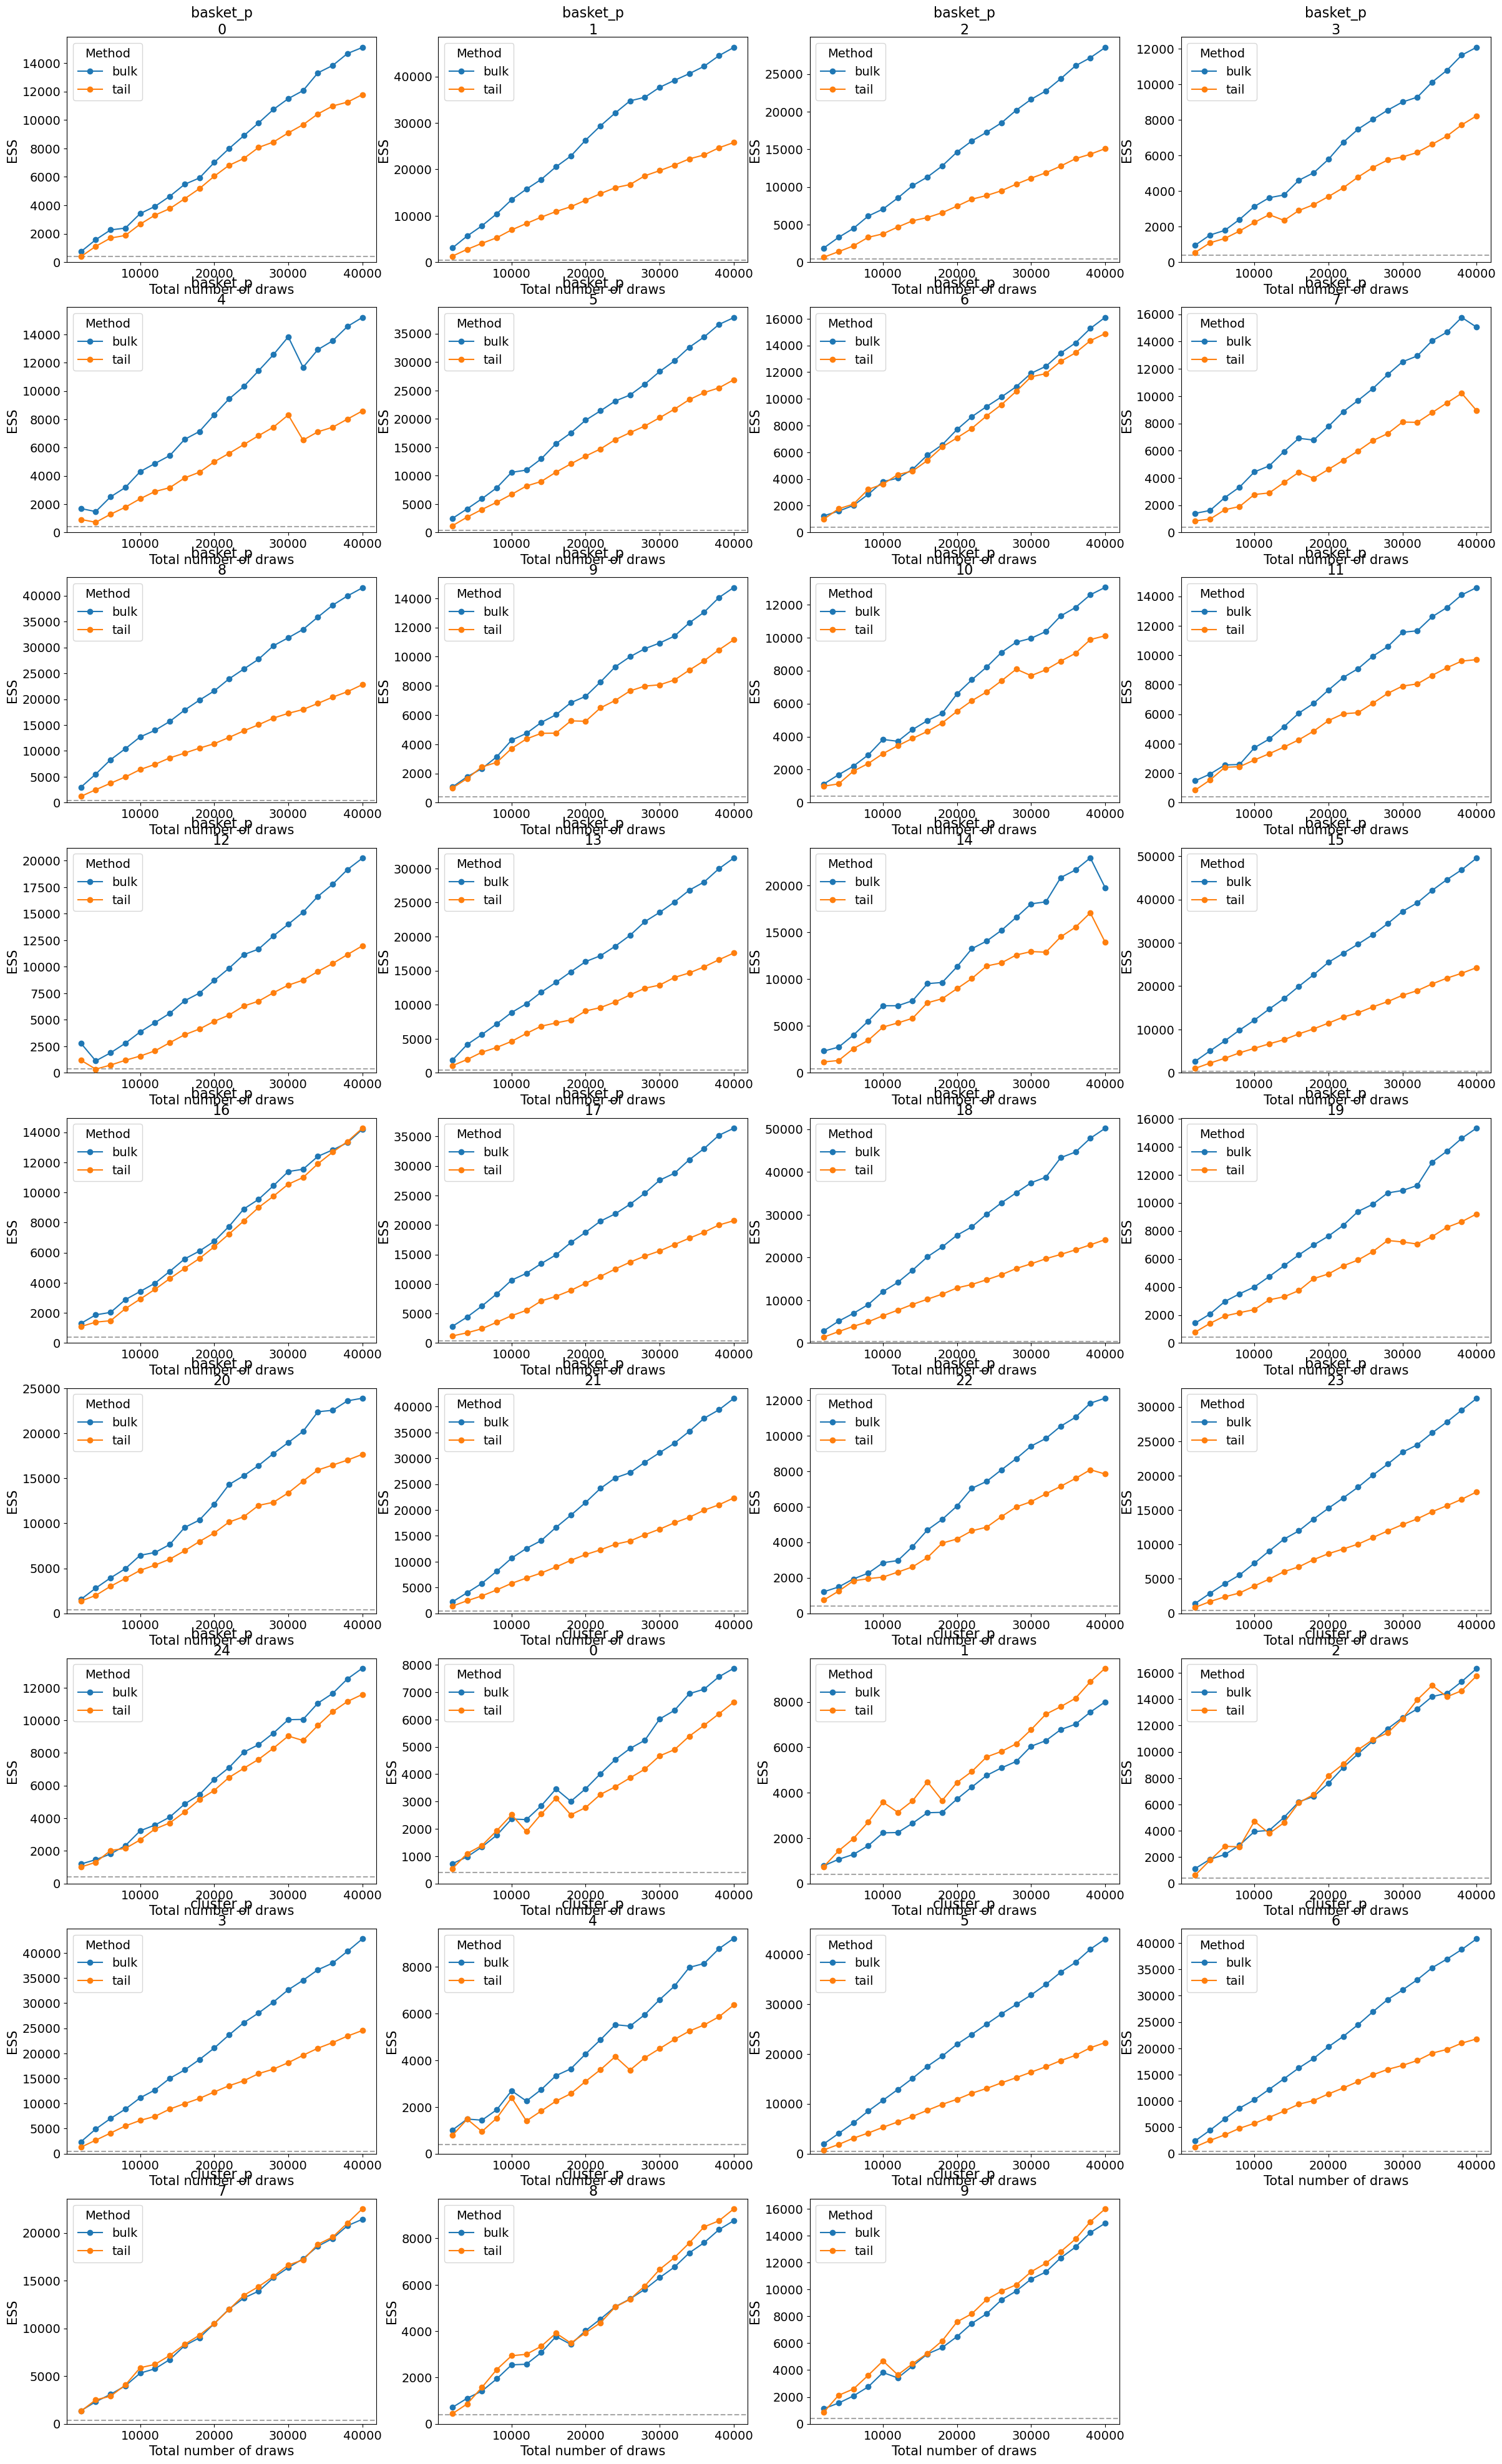

In [24]:
az.plot_ess(
    trace_h1, kind="evolution", var_names=['basket_p', 'cluster_p']
)

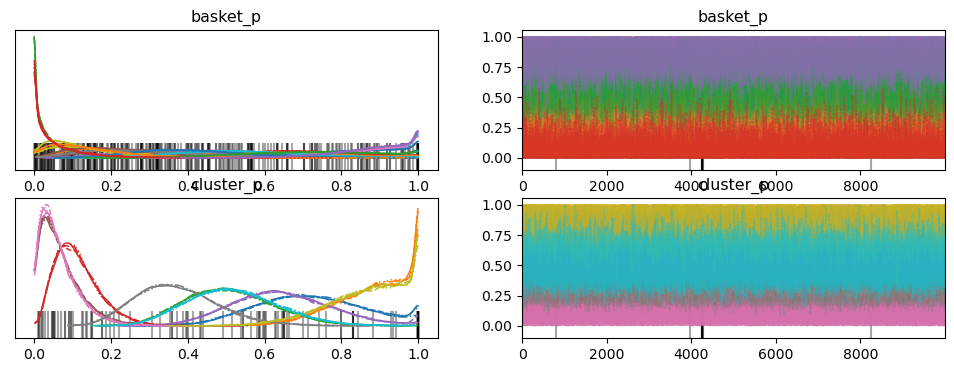

In [25]:
az.plot_trace(trace_h1, var_names=['basket_p', 'cluster_p']);

array([<AxesSubplot: title={'center': '94.0% HDI'}>], dtype=object)

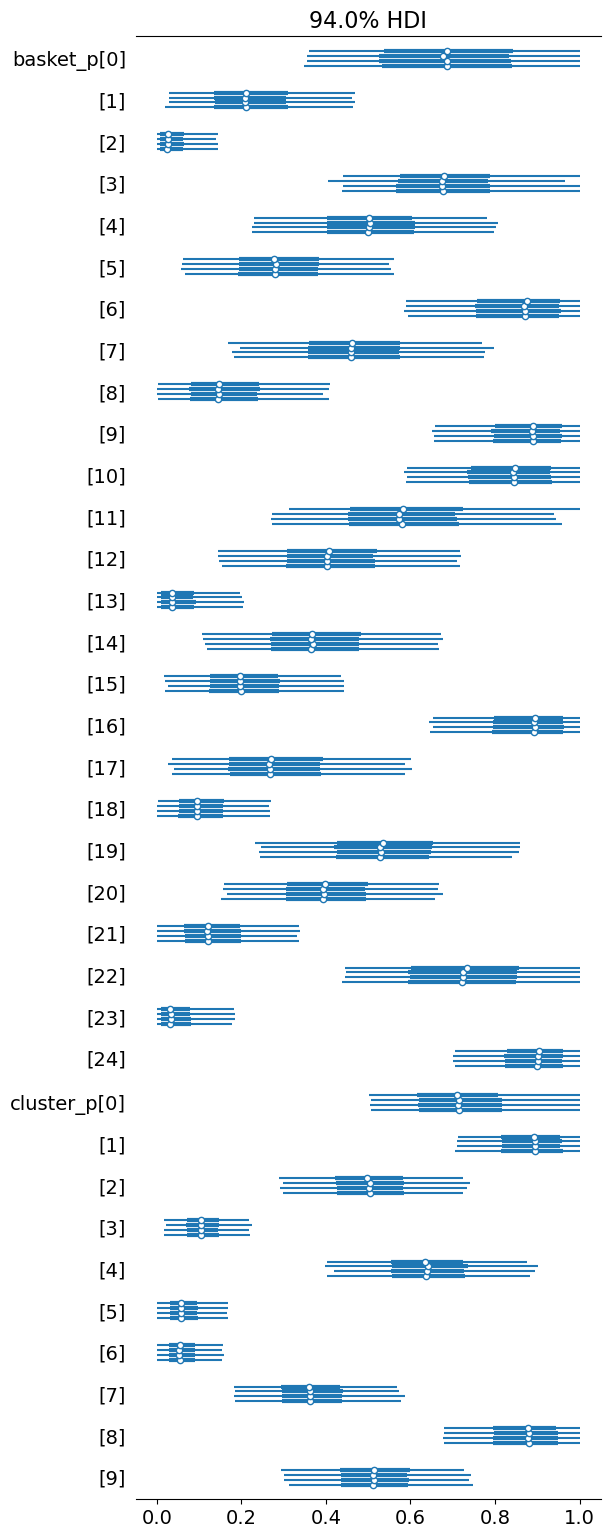

In [26]:
az.plot_forest(trace_h1, var_names=['basket_p', 'cluster_p'])

In [27]:
stacked_h1 = az.extract(trace_h1)

In [28]:
inferred_basket_p = stacked_h1.basket_p.values[:, 0]
true_basket_p, inferred_basket_p, math.sqrt(mean_squared_error(true_basket_p, inferred_basket_p))

(array([0.50003865, 0.06284339, 0.02078204, 0.4978376 , 0.36699967,
        0.59729045, 0.81434157, 0.44364733, 0.27969111, 0.92729229,
        0.78083675, 0.7572072 , 0.19772398, 0.03643975, 0.28088499,
        0.37475224, 0.74731634, 0.31107264, 0.12205197, 0.5888815 ,
        0.34109285, 0.14942324, 0.79534112, 0.00672622, 0.91240585]),
 array([0.95322008, 0.09821966, 0.09246105, 0.67952913, 0.31356829,
        0.31246945, 0.78822324, 0.43636611, 0.30161107, 0.62058896,
        0.87022733, 0.69958163, 0.32876981, 0.02560225, 0.43934847,
        0.18365758, 0.94547599, 0.2739921 , 0.06396832, 0.58645646,
        0.51260108, 0.12985558, 0.74220022, 0.00506805, 0.9100003 ]),
 0.1537422576456171)

In [29]:
inferred_cluster_p = stacked_h1.cluster_p.values[:, 0]
true_cluster_p, inferred_cluster_p, math.sqrt(mean_squared_error(true_cluster_p, inferred_cluster_p))

(array([0.75572304, 0.83887103, 0.4888386 , 0.14359827, 0.55008652,
        0.19067603, 0.04706098, 0.38199756, 0.74824909, 0.64250325]),
 array([0.79532131, 0.92002095, 0.59389712, 0.06999193, 0.66837688,
        0.00774818, 0.02330339, 0.35454247, 0.75607632, 0.53651487]),
 0.09201996368052552)

In [30]:
inferred_mat_h1 = np.outer(inferred_basket_p, inferred_cluster_p)
true_mat, inferred_mat_h1

(array([[3.77890731e-01, 4.19467938e-01, 2.44438194e-01, 7.18046864e-02,
         2.75064520e-01, 9.53453836e-02, 2.35323088e-02, 1.91013545e-01,
         3.74153465e-01, 3.21276461e-01],
        [4.74921943e-02, 5.27174953e-02, 3.07202724e-02, 9.02420154e-03,
         3.45692989e-02, 1.19827270e-02, 2.95747128e-03, 2.40060199e-02,
         4.70225057e-02, 4.03770796e-02],
        [1.57054674e-02, 1.74334522e-02, 1.01590639e-02, 2.98426520e-03,
         1.14319206e-02, 3.96263705e-03, 9.78023217e-04, 7.93868903e-03,
         1.55501433e-02, 1.33525291e-02],
        [3.76227347e-01, 4.17621541e-01, 2.43362236e-01, 7.14886194e-02,
         2.73853752e-01, 9.49256961e-02, 2.34287253e-02, 1.90172750e-01,
         3.72506531e-01, 3.19862279e-01],
        [2.77350109e-01, 3.07865393e-01, 1.79403606e-01, 5.27005189e-02,
         2.01881572e-01, 6.99780397e-02, 1.72713642e-02, 1.40192980e-01,
         2.74607170e-01, 2.35798484e-01],
        [4.51386155e-01, 5.01049654e-01, 2.91978626e-01, 8.5

### Hierarchical model 2

Another hierarchical model, but modelling the log-odds instead.

In [31]:
model_h2 = get_patient_model_hierarchical_log_odds(data)

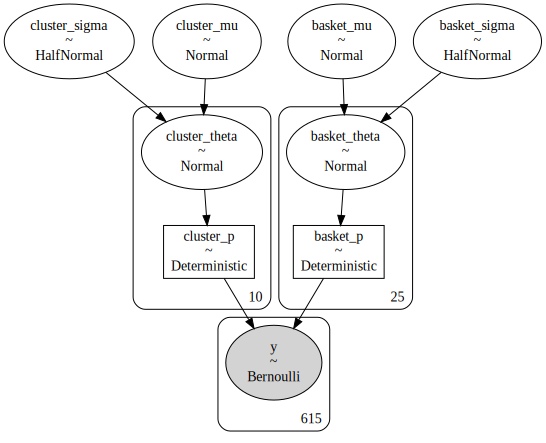

In [32]:
pm.model_to_graphviz(model_h2)

In [33]:
# with model_h2:
#     trace_h2 = pm.sample(n_sample, tune=n_burn_in, idata_kwargs={'log_likelihood': True})

This is the one we actually use after reparameterisation.

In [34]:
model_h2_nc = get_patient_model_hierarchical_log_odds_nc(data)

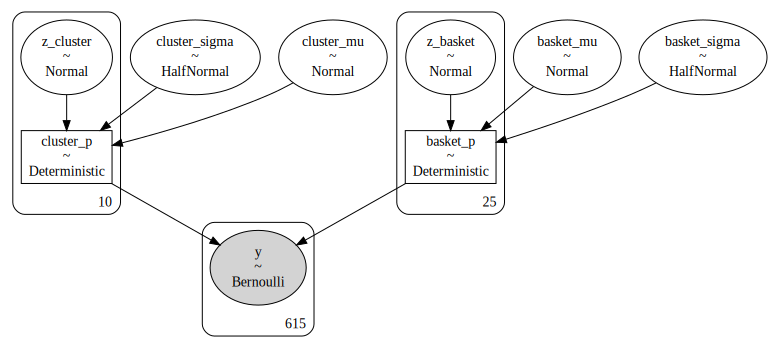

In [35]:
pm.model_to_graphviz(model_h2_nc)

In [36]:
with model_h2_nc:
    trace_h2 = pm.sample(n_sample, tune=n_burn_in, idata_kwargs={'log_likelihood': True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z_basket, z_cluster, basket_mu, cluster_mu, basket_sigma, cluster_sigma]


Sampling 4 chains for 10_000 tune and 10_000 draw iterations (40_000 + 40_000 draws total) took 113 seconds.


In [37]:
az.summary(trace_h2).round(2)

mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
z_basket[0]   0.62  0.60   -0.44     1.82        0.0      0.0   48408.0   
z_basket[1]  -0.58  0.49   -1.50     0.35        0.0      0.0   40108.0   
z_basket[2]  -1.56  0.61   -2.75    -0.47        0.0      0.0   47432.0   
z_basket[3]   0.67  0.48   -0.19     1.60        0.0      0.0   29589.0   
z_basket[4]   0.22  0.43   -0.56     1.05        0.0      0.0   30858.0   
...            ...   ...     ...      ...        ...      ...       ...   
cluster_p[5]  0.09  0.06    0.00     0.20        0.0      0.0   60325.0   
cluster_p[6]  0.08  0.06    0.00     0.18        0.0      0.0   58258.0   
cluster_p[7]  0.39  0.12    0.19     0.62        0.0      0.0   40567.0   
cluster_p[8]  0.86  0.10    0.67     1.00        0.0      0.0   39153.0   
cluster_p[9]  0.55  0.13    0.31     0.80        0.0      0.0   38435.0   

              ess_tail  r_hat  
z_basket[0]    25082.0    1.0  
z_basket[1]    27276.0    1.0  
z_basket[2]    26697.0    1.0  
z_basket[3]    20918.0    1.0  
z_basket[4]    23476.0    1.0  
...                ...    ...  
cluster_p[5]   31945.0    1.0  
cluster_p[6]   30919.0    1.0  
cluster_p[7]   33047.0    1.0  
cluster_p[8]   28978.0    1.0  
cluster_p[9]   27271.0    1.0  

[74 rows x 9 columns]

array([[<AxesSubplot: title={'center': 'basket_p\n0'}, xlabel='Total number of draws', ylabel='ESS'>,
        <AxesSubplot: title={'center': 'basket_p\n1'}, xlabel='Total number of draws', ylabel='ESS'>,
        <AxesSubplot: title={'center': 'basket_p\n2'}, xlabel='Total number of draws', ylabel='ESS'>,
        <AxesSubplot: title={'center': 'basket_p\n3'}, xlabel='Total number of draws', ylabel='ESS'>],
       [<AxesSubplot: title={'center': 'basket_p\n4'}, xlabel='Total number of draws', ylabel='ESS'>,
        <AxesSubplot: title={'center': 'basket_p\n5'}, xlabel='Total number of draws', ylabel='ESS'>,
        <AxesSubplot: title={'center': 'basket_p\n6'}, xlabel='Total number of draws', ylabel='ESS'>,
        <AxesSubplot: title={'center': 'basket_p\n7'}, xlabel='Total number of draws', ylabel='ESS'>],
       [<AxesSubplot: title={'center': 'basket_p\n8'}, xlabel='Total number of draws', ylabel='ESS'>,
        <AxesSubplot: title={'center': 'basket_p\n9'}, xlabel='Total number of d

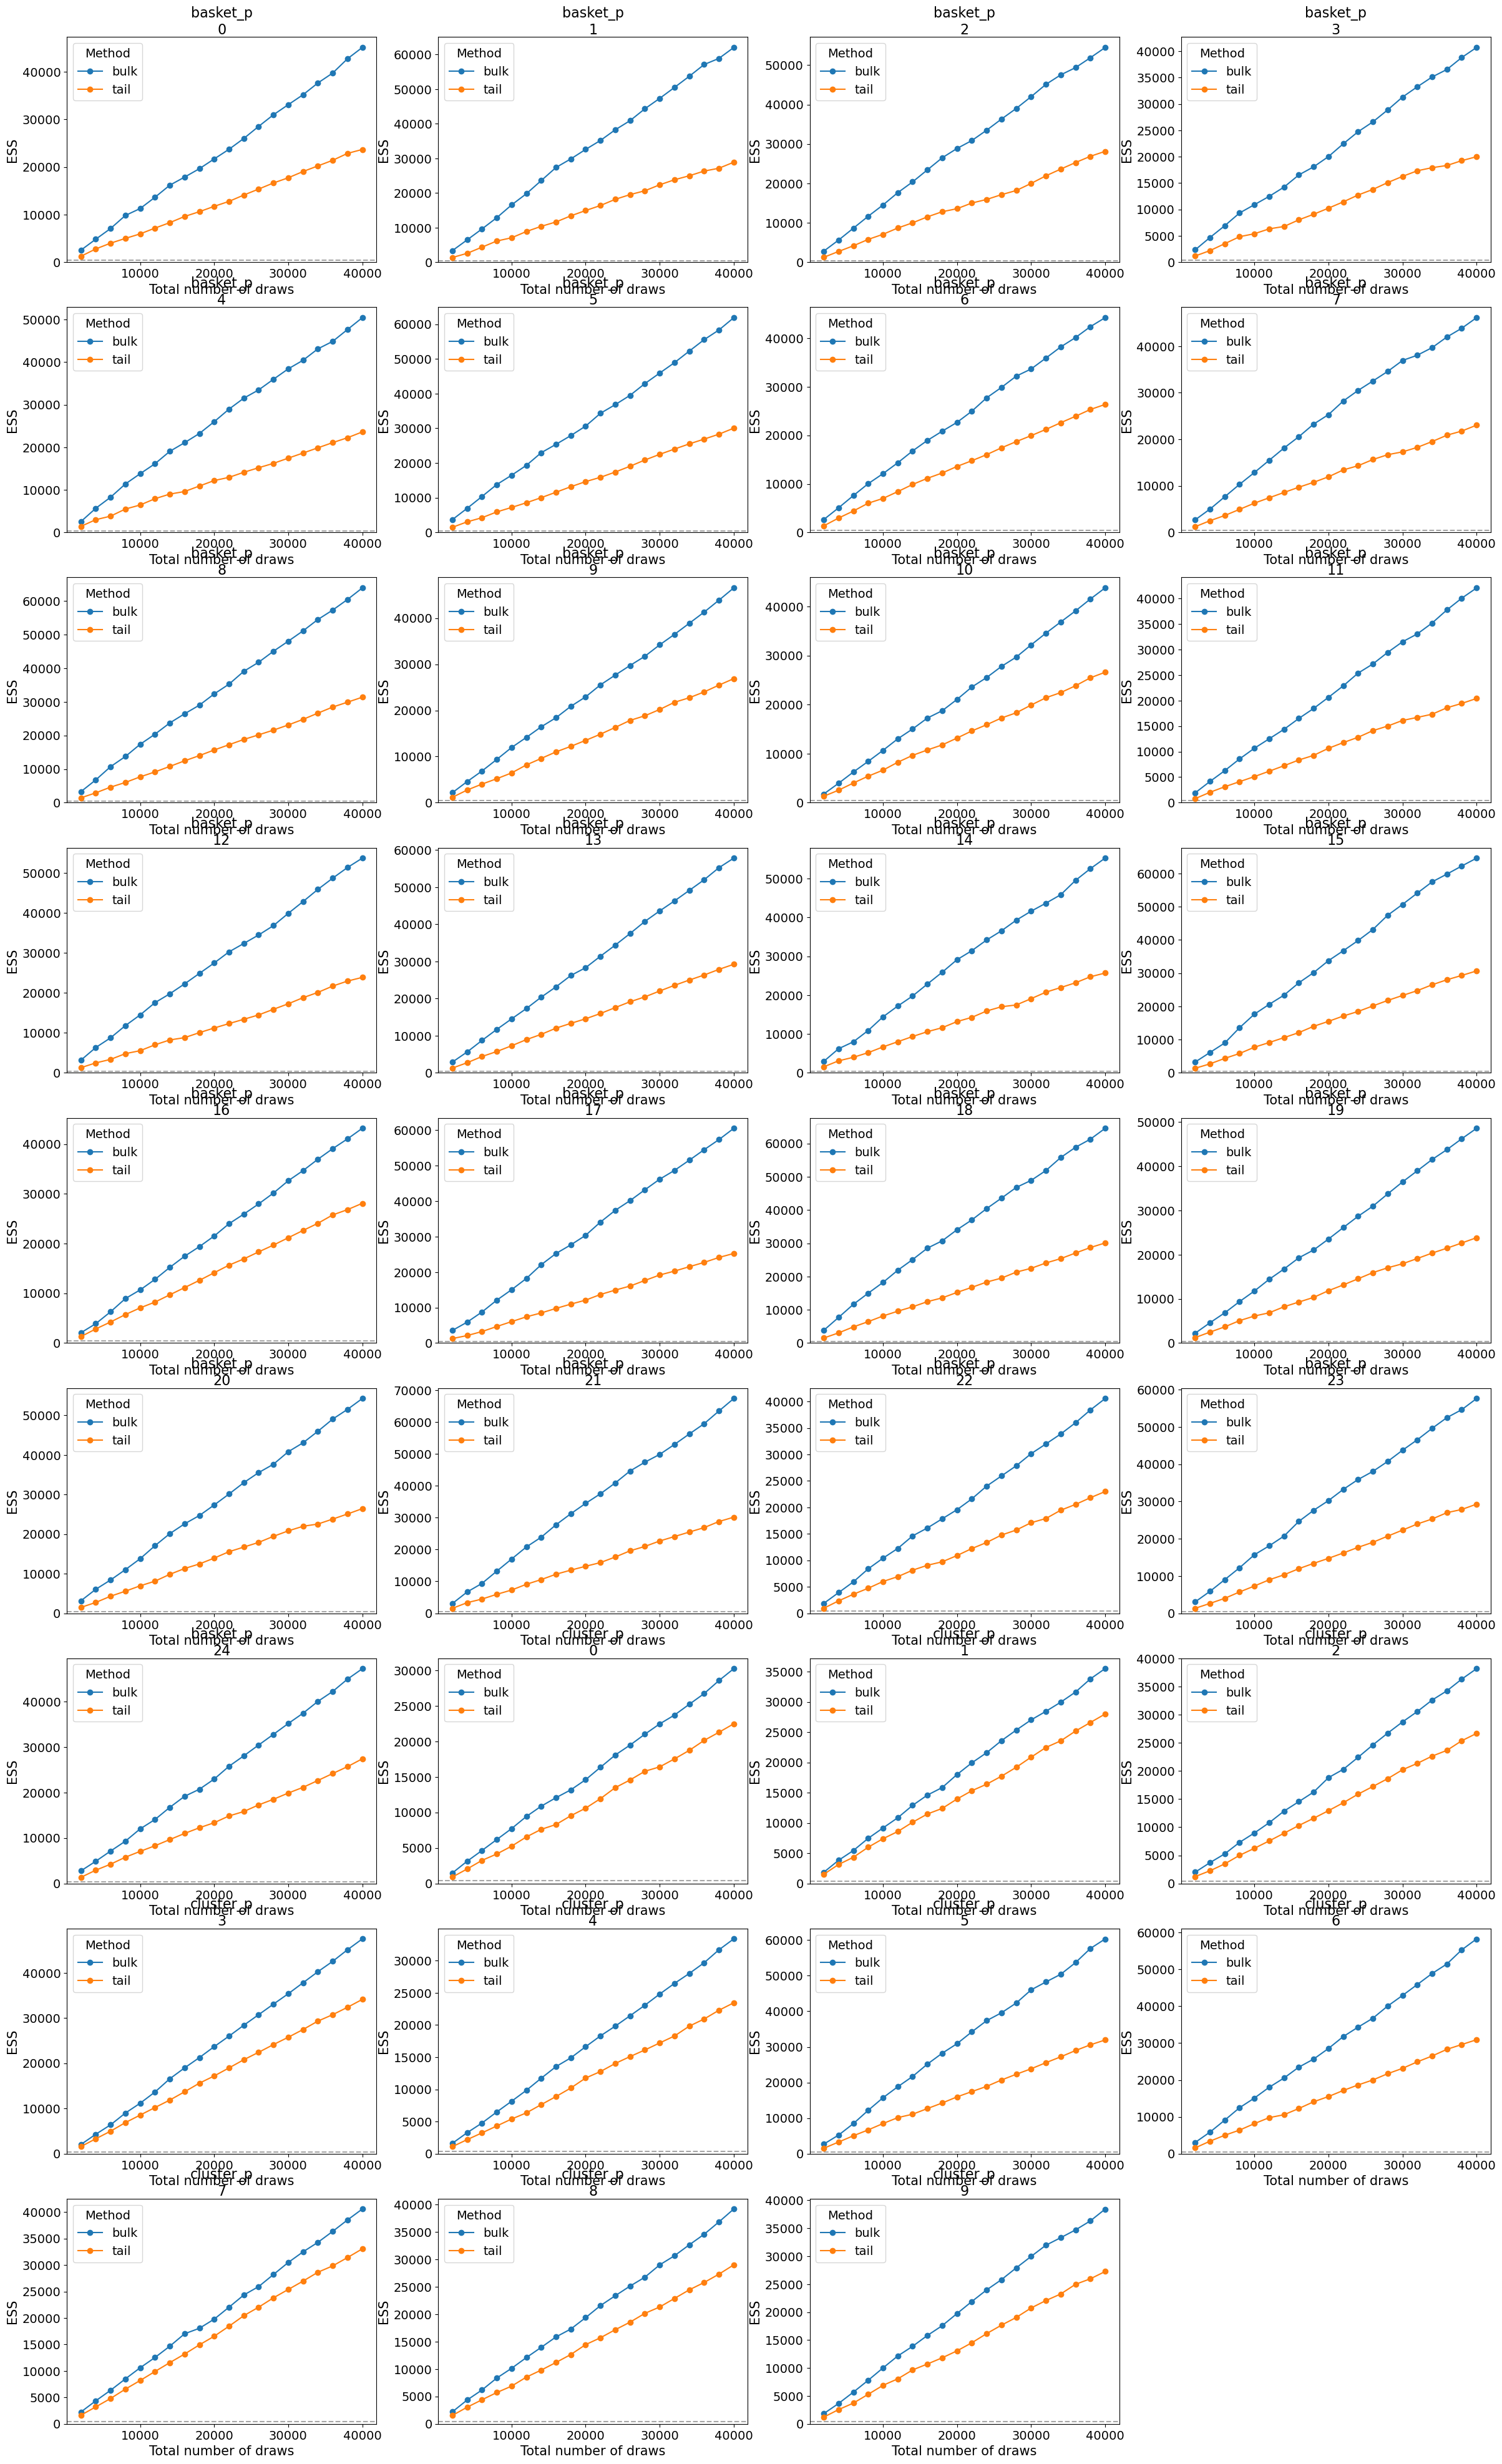

In [38]:
az.plot_ess(
    trace_h2, kind="evolution", var_names=['basket_p', 'cluster_p']
)

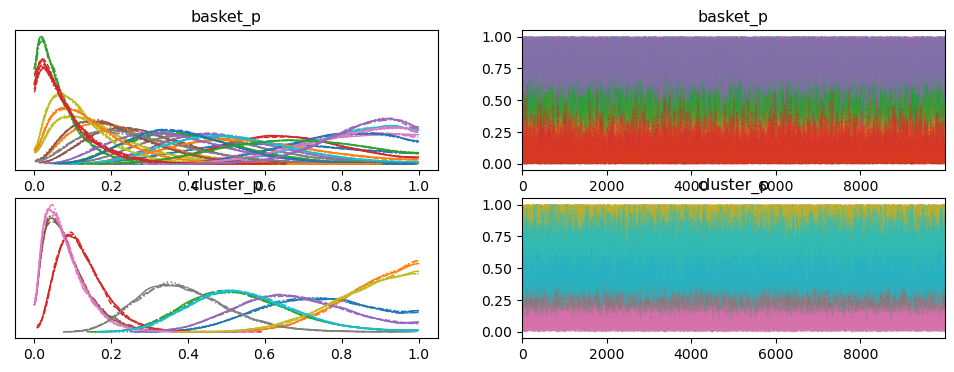

In [39]:
az.plot_trace(trace_h2, var_names=['basket_p', 'cluster_p']);

array([<AxesSubplot: title={'center': '94.0% HDI'}>], dtype=object)

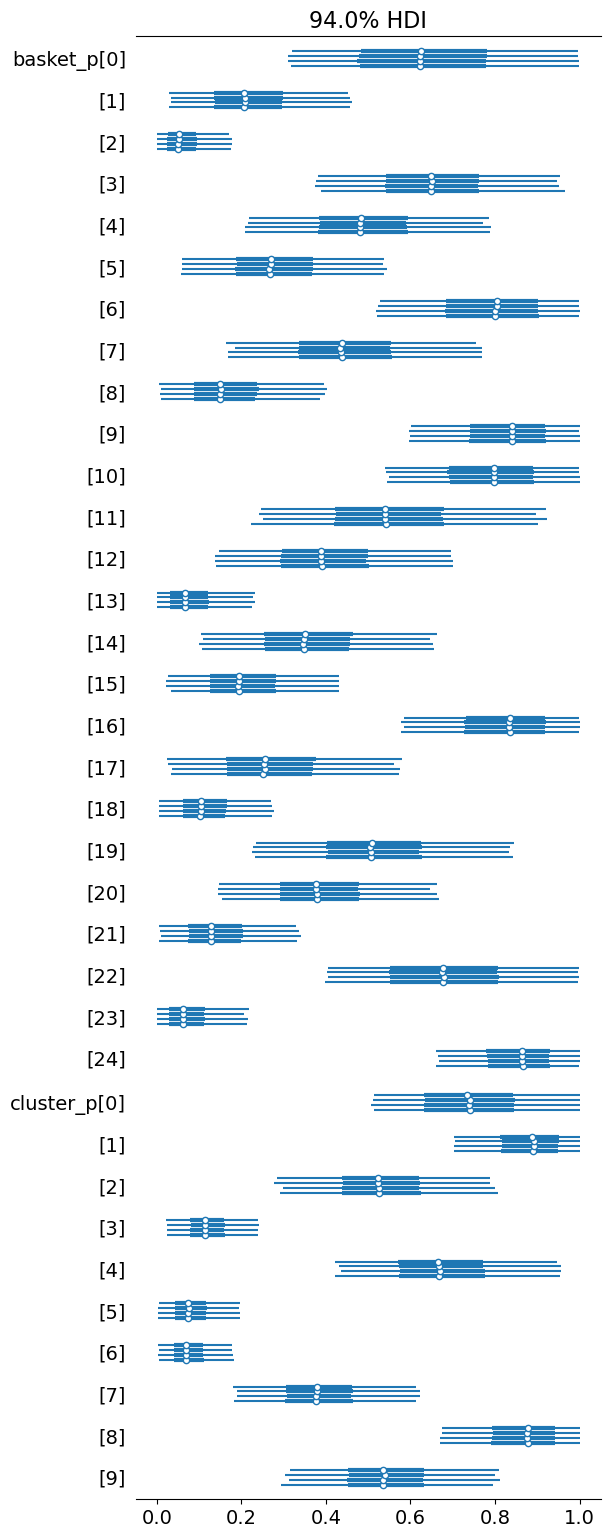

In [40]:
az.plot_forest(trace_h2, var_names=['basket_p', 'cluster_p'])

In [41]:
stacked_h2 = az.extract(trace_h2)

In [42]:
inferred_basket_p = stacked_h2.basket_p.values[:, 0]
true_basket_p, inferred_basket_p, math.sqrt(mean_squared_error(true_basket_p, inferred_basket_p))

(array([0.50003865, 0.06284339, 0.02078204, 0.4978376 , 0.36699967,
        0.59729045, 0.81434157, 0.44364733, 0.27969111, 0.92729229,
        0.78083675, 0.7572072 , 0.19772398, 0.03643975, 0.28088499,
        0.37475224, 0.74731634, 0.31107264, 0.12205197, 0.5888815 ,
        0.34109285, 0.14942324, 0.79534112, 0.00672622, 0.91240585]),
 array([0.31888321, 0.19221398, 0.06194507, 0.41772316, 0.44194686,
        0.22570827, 0.78128246, 0.42571153, 0.23405619, 0.84629496,
        0.83140696, 0.47309493, 0.13152245, 0.03304979, 0.29551696,
        0.22638586, 0.79510762, 0.12199316, 0.04050946, 0.45388221,
        0.44534672, 0.1294221 , 0.59924247, 0.06520717, 0.71140009]),
 0.13824164229669209)

In [43]:
inferred_cluster_p = stacked_h2.cluster_p.values[:, 0]
true_cluster_p, inferred_cluster_p, math.sqrt(mean_squared_error(true_cluster_p, inferred_cluster_p))

(array([0.75572304, 0.83887103, 0.4888386 , 0.14359827, 0.55008652,
        0.19067603, 0.04706098, 0.38199756, 0.74824909, 0.64250325]),
 array([0.95391805, 0.94088123, 0.5678297 , 0.23840779, 0.88376843,
        0.0998787 , 0.22519425, 0.394306  , 0.97478081, 0.33897444]),
 0.18969261457312606)

In [44]:
inferred_mat_h2 = np.outer(inferred_basket_p, inferred_cluster_p)
true_mat, inferred_mat_h2

(array([[3.77890731e-01, 4.19467938e-01, 2.44438194e-01, 7.18046864e-02,
         2.75064520e-01, 9.53453836e-02, 2.35323088e-02, 1.91013545e-01,
         3.74153465e-01, 3.21276461e-01],
        [4.74921943e-02, 5.27174953e-02, 3.07202724e-02, 9.02420154e-03,
         3.45692989e-02, 1.19827270e-02, 2.95747128e-03, 2.40060199e-02,
         4.70225057e-02, 4.03770796e-02],
        [1.57054674e-02, 1.74334522e-02, 1.01590639e-02, 2.98426520e-03,
         1.14319206e-02, 3.96263705e-03, 9.78023217e-04, 7.93868903e-03,
         1.55501433e-02, 1.33525291e-02],
        [3.76227347e-01, 4.17621541e-01, 2.43362236e-01, 7.14886194e-02,
         2.73853752e-01, 9.49256961e-02, 2.34287253e-02, 1.90172750e-01,
         3.72506531e-01, 3.19862279e-01],
        [2.77350109e-01, 3.07865393e-01, 1.79403606e-01, 5.27005189e-02,
         2.01881572e-01, 6.99780397e-02, 1.72713642e-02, 1.40192980e-01,
         2.74607170e-01, 2.35798484e-01],
        [4.51386155e-01, 5.01049654e-01, 2.91978626e-01, 8.5

## 3. Calculate RMSE

Calculate root mean squared error for basket_p

In [45]:
actual = true_basket_p

predicted = np.mean(stacked_s.basket_p.values, axis=1)
rmse_s = math.sqrt(mean_squared_error(actual, predicted))

predicted = np.mean(stacked_h1.basket_p.values, axis=1)
rmse_h1 = math.sqrt(mean_squared_error(actual, predicted))

predicted = np.mean(stacked_h2.basket_p.values, axis=1)
rmse_h2 = math.sqrt(mean_squared_error(actual, predicted))

rmse_basket_p = pd.DataFrame({
    'method': ['s', 'h1', 'h2'],
    'RMSE': [rmse_s, rmse_h1, rmse_h2]
})
rmse_basket_p

method      RMSE
0      s  0.194509
1     h1  0.121143
2     h2  0.120147

Calculate root mean squared error for cluster_p

In [46]:
actual = true_cluster_p

predicted = np.mean(stacked_s.cluster_p.values, axis=1)
rmse_s = math.sqrt(mean_squared_error(actual, predicted))

predicted = np.mean(stacked_h1.cluster_p.values, axis=1)
rmse_h1 = math.sqrt(mean_squared_error(actual, predicted))

predicted = np.mean(stacked_h2.cluster_p.values, axis=1)
rmse_h2 = math.sqrt(mean_squared_error(actual, predicted))

rmse_cluster_p = pd.DataFrame({
    'method': ['s', 'h1', 'h2'],
    'RMSE': [rmse_s, rmse_h1, rmse_h2]
})
rmse_cluster_p

method      RMSE
0      s  0.178665
1     h1  0.075091
2     h2  0.072588

Make plot

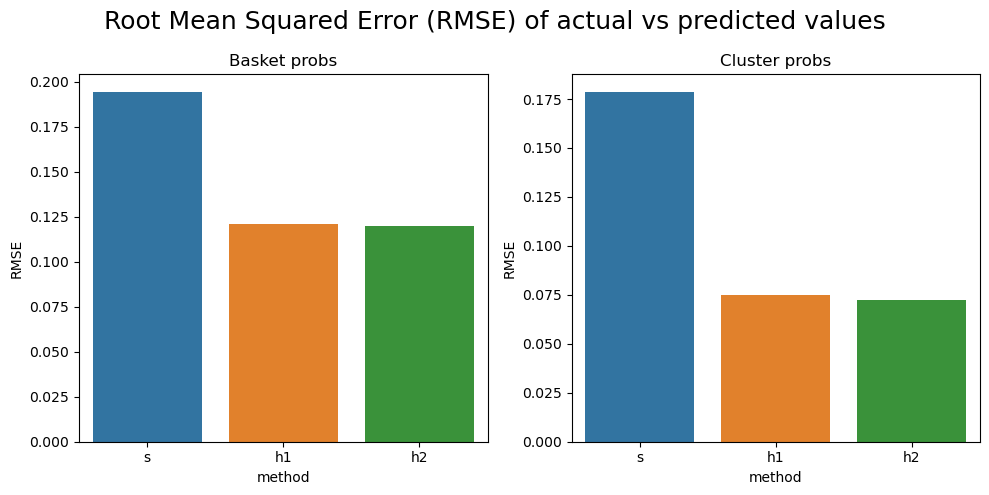

In [47]:
methods = rmse_basket_p['method'].unique()
colors = sns.color_palette("deep", len(methods))
color_map = dict(zip(methods, colors))

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

sns.barplot(x='method', y='RMSE', data=rmse_basket_p, ax=ax1)
ax1.set_title('Basket probs')

sns.barplot(x='method', y='RMSE', data=rmse_cluster_p, ax=ax2)
ax2.set_title('Cluster probs')

plt.suptitle('Root Mean Squared Error (RMSE) of actual vs predicted values', size=18)
plt.tight_layout()

Compare the matrices

Text(1452.626811594203, 0.5, 'Baskets')

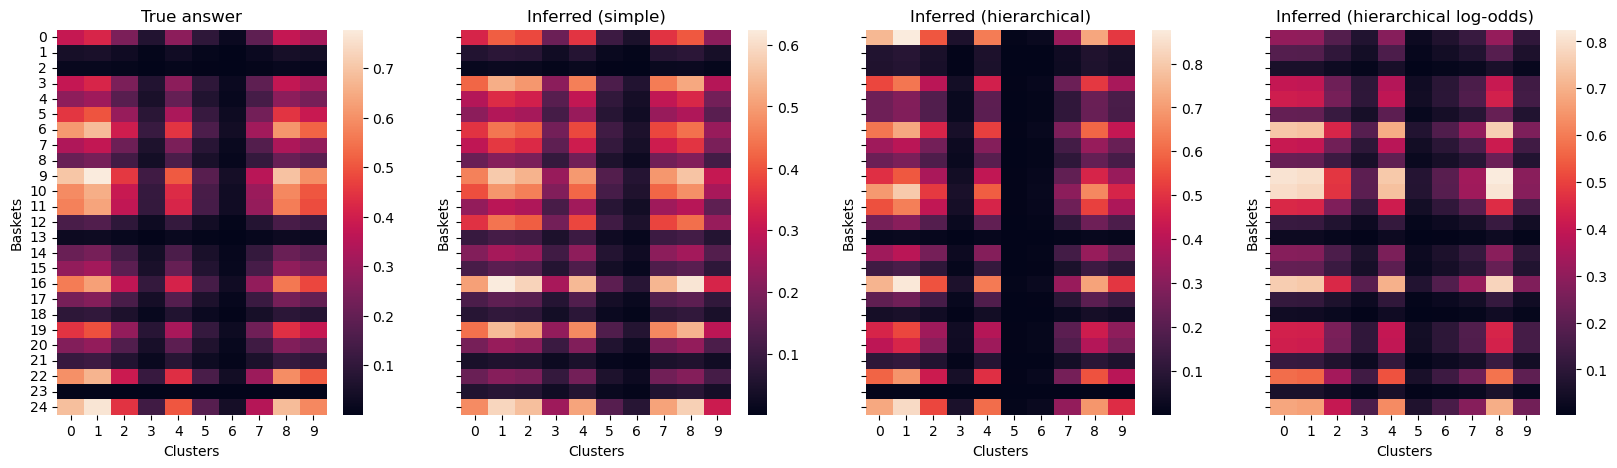

In [48]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5), sharex=True, sharey=True)

sns.heatmap(true_mat, ax=ax[0])
ax[0].set_title('True answer')
ax[0].set_xlabel('Clusters')
ax[0].set_ylabel('Baskets')
    
sns.heatmap(inferred_mat_s, ax=ax[1])
ax[1].set_title('Inferred (simple)')
ax[1].set_xlabel('Clusters')
ax[1].set_ylabel('Baskets')
    
sns.heatmap(inferred_mat_h1, ax=ax[2])
ax[2].set_title('Inferred (hierarchical)')
ax[2].set_xlabel('Clusters')
ax[2].set_ylabel('Baskets')
    
sns.heatmap(inferred_mat_h2, ax=ax[3])
ax[3].set_title('Inferred (hierarchical log-odds)')
ax[3].set_xlabel('Clusters')
ax[3].set_ylabel('Baskets')

Check top and bottom partitions

In [49]:
def get_indices(arr, N):
    # Get the indices of the top-3 largest values
    top_indices = np.argpartition(arr, -N, axis=None)[-N:]
    top_indices = np.unravel_index(top_indices, arr.shape)

    # Get the indices of the top-3 smallest values
    bottom_indices = np.argpartition(arr, N, axis=None)[:N]
    bottom_indices = np.unravel_index(bottom_indices, arr.shape)

    return top_indices, bottom_indices

In [50]:
def count_overlap(true_indices, inferred_indices):
    a = set(zip(true_indices[0], true_indices[1]))
    b = set(zip(inferred_indices[0], inferred_indices[1]))
    return a.intersection(b)

In [51]:
plot_data = []
for N in list(range(5, 55, 5)):

    true_top_indices, true_bottom_indices = get_indices(true_mat, N)

    inferred_top_indices_s, inferred_bottom_indices_s = get_indices(inferred_mat_s, N)
    inferred_top_indices_h1, inferred_bottom_indices_h1 = get_indices(inferred_mat_h1, N)
    inferred_top_indices_h2, inferred_bottom_indices_h2 = get_indices(inferred_mat_h2, N)

    top_overlap_s = len(count_overlap(true_top_indices, inferred_top_indices_s))
    bottom_overlap_s = len(count_overlap(true_bottom_indices, inferred_bottom_indices_s))    
    plot_data.append(['s', top_overlap_s, bottom_overlap_s, (top_overlap_s+bottom_overlap_s), N])

    top_overlap_h1 = len(count_overlap(true_top_indices, inferred_top_indices_h1))
    bottom_overlap_h1 = len(count_overlap(true_bottom_indices, inferred_bottom_indices_h1))
    plot_data.append(['h1', top_overlap_h1, bottom_overlap_h1, (top_overlap_h1+bottom_overlap_h1), N])

    top_overlap_h2 = len(count_overlap(true_top_indices, inferred_top_indices_h2))
    bottom_overlap_h2 = len(count_overlap(true_bottom_indices, inferred_bottom_indices_h2))
    plot_data.append(['h2', top_overlap_h2, bottom_overlap_h2, (top_overlap_h2+bottom_overlap_h2), N])
    
df = pd.DataFrame(plot_data, columns=['method', 'top', 'bottom', 'total', 'N'])
df

method  top  bottom  total   N
0       s    1       2      3   5
1      h1    1       3      4   5
2      h2    3       2      5   5
3       s    4       5      9  10
4      h1    4       4      8  10
5      h2    4       2      6  10
6       s    5       7     12  15
7      h1    8       8     16  15
8      h2    8       5     13  15
9       s    5      10     15  20
10     h1   11      11     22  20
11     h2   13      10     23  20
12      s   10      13     23  25
13     h1   16      16     32  25
14     h2   18      12     30  25
15      s   14      19     33  30
16     h1   19      18     37  30
17     h2   23      17     40  30
18      s   17      25     42  35
19     h1   22      19     41  35
20     h2   25      19     44  35
21      s   20      29     49  40
22     h1   27      23     50  40
23     h2   29      22     51  40
24      s   25      33     58  45
25     h1   34      26     60  45
26     h2   33      27     60  45
27      s   28      35     63  50
28     h1   40      30     70  50
29     h2   36      29     65  50

Text(0.5, 1.0, 'Correct most-responsive partitions')

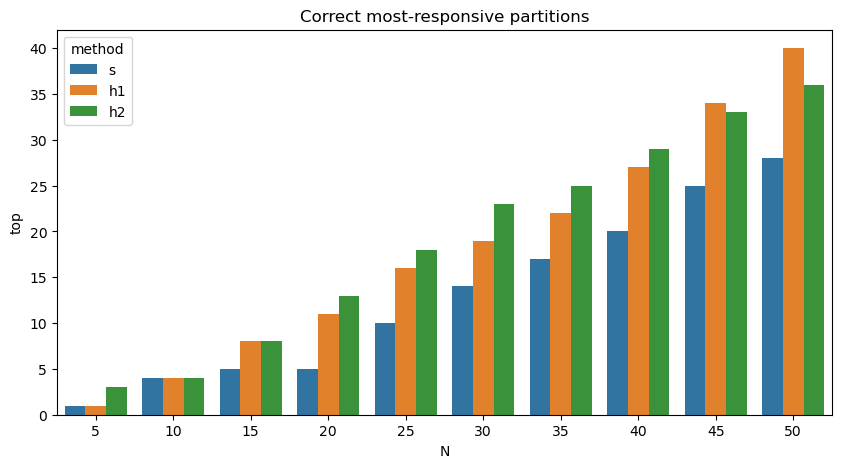

In [52]:
plt.figure(figsize=(10, 5))
sns.barplot(x='N', y='top', data=df, hue='method')
plt.title('Correct most-responsive partitions')

Text(0.5, 1.0, 'Correct least-responsive partitions')

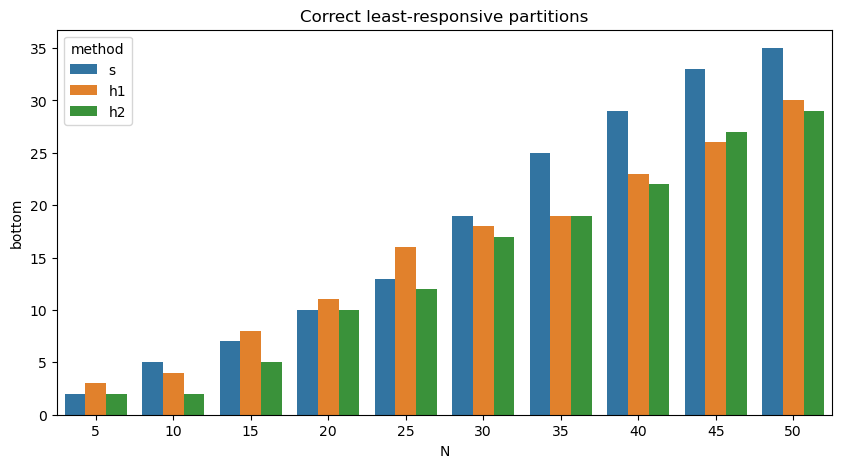

In [53]:
plt.figure(figsize=(10, 5))
sns.barplot(x='N', y='bottom', data=df, hue='method')
plt.title('Correct least-responsive partitions')

## 4. Model comparison

In [54]:
# import warnings
# warnings.filterwarnings("ignore", category=UserWarning, module="arviz.stats.stats")

In [55]:
loo_s = az.loo(trace_s)
loo_s

Computed from 40000 posterior samples and 615 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -257.53    12.27
p_loo       17.96        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      615  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [56]:
loo_h1 = az.loo(trace_h1)
loo_h1

/opt/anaconda3/envs/pyBasket/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 40000 posterior samples and 615 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -249.25    14.15
p_loo       28.26        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      609   99.0%
 (0.5, 0.7]   (ok)          5    0.8%
   (0.7, 1]   (bad)         1    0.2%
   (1, Inf)   (very bad)    0    0.0%

In [57]:
loo_h2 = az.loo(trace_h2)
loo_h2

Computed from 40000 posterior samples and 615 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -249.20    13.53
p_loo       25.69        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      613   99.7%
 (0.5, 0.7]   (ok)          2    0.3%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [58]:
ic = 'loo'
df_comp_loo = az.compare({
    's': loo_s, 
    'h1': loo_h1,
    'h2': loo_h2,    
}, ic=ic)
df_comp_loo

rank    elpd_loo      p_loo  elpd_diff        weight         se       dse  \
h2     0 -249.200295  25.692636   0.000000  8.136902e-16  13.530856  0.000000   
h1     1 -249.254752  28.258047   0.054457  8.376334e-01  14.147955  1.209546   
s      2 -257.528193  17.959618   8.327898  1.623666e-01  12.267651  3.935689   

    warning scale  
h2    False   log  
h1     True   log  
s     False   log

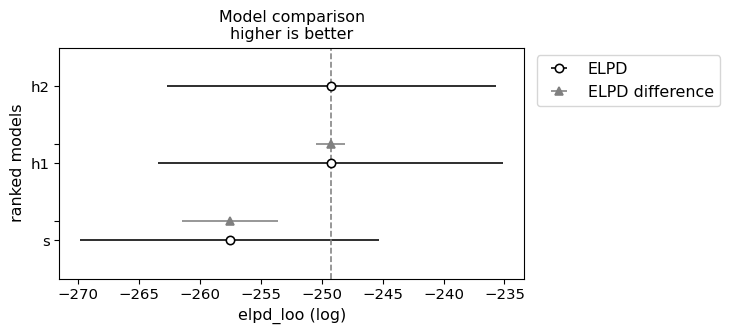

In [59]:
az.plot_compare(df_comp_loo);